# GENERAL TOPIC ANALYSIS STUDY AND CBF RECOMENDER

### V3 - June 26th

This notebook analyze mainly keyword based fields (jobroles, titles and tags) and some facts related to items,user & interactions.
Then It will try to approach a topic model for item similarity and/or CB recommedation for non-cold users.
The final CB Recommendation part is in another notebook called "Recys-Snippet-Helper-Target-Non-Cold-User-V3"

Quick links:

- Go to <a href="#analysis_int">Inits & datasets loading</a>
- Go to <a href="#analysis_int">Basic Interactions Analysis</a>
- Go to <a href="#keywords">Keyword based fields</a>
- Go to <a href="#topics">Topics modelling</a>


### Load users, items & interactions

In [1]:
import numpy as np
import pandas as pd
import time

#start timer
t_start = time.time()

userData=pd.read_table('datasets/users.csv',header=0,dtype=object)
userData.columns = ['id','jobroles','career_level','discipline_id','industry_id','country','region',\
                    'experience_n_entries_class','experience_years_experience','experience_years_in_current',\
                    'edu_degree','edu_fieldofstudies','wtcj','premium']

userData['id']=userData['id'].astype(np.int32)
userData['jobroles']=userData['jobroles'].apply(lambda x: [] if x=='0' else [np.int32(i) for i in x.split(',')])
userData['career_level']=userData['career_level'].astype(np.int8)
userData['discipline_id']=userData['discipline_id'].astype(np.int8)
userData['industry_id']=userData['industry_id'].astype(np.int8)
userData['region']=userData['region'].astype(np.int8)
userData['experience_n_entries_class']=userData['experience_n_entries_class'].astype(np.int8)
userData['experience_years_experience']=userData['experience_years_experience'].astype(np.int8)
userData['experience_years_in_current']=userData['experience_years_in_current'].astype(np.int8)
userData['edu_degree']=userData['edu_degree'].astype(np.int8)
userData['edu_fieldofstudies']=userData['edu_fieldofstudies'].apply(lambda x: [] if pd.isnull(x) else [np.int32(i) for i in x.split(',')])
userData['wtcj']=userData['wtcj'].astype(np.int8)
userData['premium']=userData['premium'].astype(np.int8)

#end timer
t_end=time.time()
print "Time invested "+str((t_end-t_start))+" s"

# Show structure
print userData.shape

Time invested 22.7300000191 s
(1497020, 14)


In [2]:
## Load items
import numpy as np
import pandas as pd
import time

#start timer
t_start = time.time()

itemData=pd.read_table('datasets/items.csv',header=0,dtype=object,nrows=10000000)
itemData.columns = ['id','title','career_level','discipline_id','industry_id','country','is_payed','region',\
                    'latitude','longitude','employment','tags','created_at']

itemData['id']=itemData['id'].astype(np.int32)
itemData['title']=itemData['title'].apply(lambda x: [] if pd.isnull(x) else [np.int32(i) for i in x.split(',')])
itemData['career_level']=itemData['career_level'].astype(np.int8)
itemData['discipline_id']=itemData['discipline_id'].astype(np.int8)
itemData['industry_id']=itemData['industry_id'].astype(np.int8)
itemData['is_payed']=itemData['is_payed'].astype(np.int8)
itemData['region']=itemData['region'].astype(np.int8)
itemData['employment']=itemData['employment'].astype(np.int8)                             
itemData['tags']=itemData['tags'].apply(lambda x: [] if pd.isnull(x) else [np.int32(i) for i in x.split(',')])

#end timer
t_end=time.time()
print "Time invested "+str((t_end-t_start))+" s"

# Show structure
print itemData.shape

Time invested 35.8550000191 s
(1306054, 13)


### Let's go for interactions

In [3]:
## Load interactions
import numpy as np
import pandas as pd
import time

### DRAFT VERSION --- We need to agree on source files
def apiRecsysLoad12345Interactions():
    interactionsData=pd.read_pickle('datasets/interactions123DataAll.pkl')
    interactionsData=interactionsData.append(pd.read_pickle('datasets/interactions4Data.pkl'),ignore_index=False,verify_integrity=True)
    interactionsData=interactionsData.append(pd.read_pickle('datasets/interactions5Data.pkl'),ignore_index=False,verify_integrity=True)
    #interactionsData=interactionsData.append(pd.read_pickle('datasets/interactions0Data-lastweek.pkl'),ignore_index=False,verify_integrity=True)
    return interactionsData

#start timer
t_start = time.time()

interactionsData=apiRecsysLoad12345Interactions()

#end timer
t_end=time.time()
print "Time invested "+str((t_end-t_start))+" s"

# Show structure
print interactionsData.shape

n_users=len(set(userData['id'].unique()))
n_items=len(set(itemData['id'].unique()))
n_users_int=len(set(userData['id'].unique()).intersection(set(interactionsData['user_id'].unique())))
n_items_int=len(set(itemData['id'].unique()).intersection(set(interactionsData['item_id'].unique())))

print "User volume with interactions:",len(set(userData['id'].unique()).intersection(set(interactionsData['user_id'].unique())))
print "Item volume with interactions:",len(set(itemData['id'].unique()).intersection(set(interactionsData['item_id'].unique())))

print "User volume with interactions:",(n_users_int*100.0/n_users),"%"
print "Item volume with interactions:",(n_items_int*100.0/n_items),"%"

interactionsData.head(5)

Time invested 4.89499998093 s
(8274901, 5)
User volume with interactions: 689144
Item volume with interactions: 538683
User volume with interactions: 46.0343883181 %
Item volume with interactions: 41.2450786874 %


,user_id,item_id,interaction_type,created_at,created_at_date
0,2082156,80,1,1484299172,2017-01-13 09:19:32
1,1934123,140,1,1486388563,2017-02-06 13:42:43
2,1320213,240,1,1479409825,2016-11-17 19:10:25
3,297303,310,1,1484817366,2017-01-19 09:16:06
4,1635596,310,1,1486370081,2017-02-06 08:34:41


# BASIC ANALYSIS ON INTERACTIONS AND THEIR USERS

Interactions are all transactions between a user and an item including recruiter interests as well as impressions. Fields:

    user_id ID of the user who performed the interaction (points to users.id)
    item_id ID of the item on which the interaction was performed (points to items.id)
    created_at a unix time stamp timestamp representing the time when the interaction got created
    interaction_type the type of interaction that was performed on the item:
        0 = XING showed this item to a user (= impression)
        1 = the user clicked on the item
        2 = the user bookmarked the item on XING
        3 = the user clicked on the reply button or application form button that is shown on some job postings
        4 = the user deleted a recommendation from his/her list of recommendation (clicking on "x") which has the effect that the recommendation will no longer been shown to the user and that a new recommendation item will be loaded and displayed to the user
        5 = a recruiter from the items company showed interest into the user. (e.g. clicked on the profile)

### Show interactions type distribution

Show distributions of type of interactions


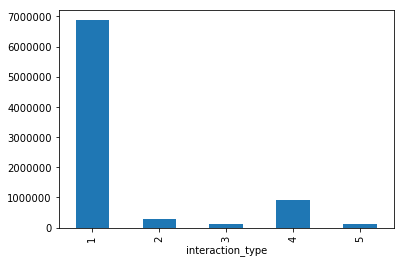

In [7]:
%matplotlib inline

print "Show distributions of type of interactions"
interactionsData.groupby(['interaction_type'])['interaction_type'].size().plot(kind='bar')

## Let's focus now on keyword based fields

- job roles -- users
- titles -- items
- tags -- items


## Some captures about jobs postings

See a screenshot of recomendation newsfeed:
<img src="recomendations.jpg">

Now, see examples of job postings:
<img src="job1.jpg">
<img src="job2.jpg">

### Let's focus on studying uniques keywords and intersections

There are 12676 different job roles keywords


,count
jobrole,
1762890,114965
1467121,75560
1762618,71342
2891417,57766
3614810,55878


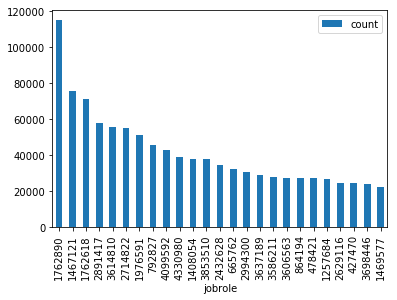

In [8]:
## CALCULATE UNIQUE TAGS FOR JOB ROLES, TITLE and TAGS
## and do counts, show populars and look for intersection
import collections 
import matplotlib.pyplot as plt

## JOB ROLES

#start timer
t_start = time.time()

cnt=collections.Counter()
for l in userData['jobroles']:
    cnt.update(l)
    
bag_jobroles=set(cnt.keys())
print "There are",len(bag_jobroles),"different job roles keywords"

#end timer
t_end=time.time()

t=pd.DataFrame(cnt.most_common(25),columns=['jobrole','count']).set_index(['jobrole'])
t.plot(kind='bar')
t.head()

There are 11329 different title keywords


,count
title,
2103114,46688
3859656,44052
4347966,42018
1976591,41554
2945601,40303


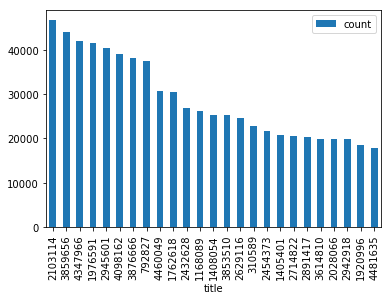

In [9]:
## TITLE

#start timer
t_start = time.time()

cnt=collections.Counter()
for l in itemData['title']:
    cnt.update(l)
    
bag_title=set(cnt.keys())
print "There are",len(bag_title),"different title keywords"

#end timer
t_end=time.time()

t=pd.DataFrame(cnt.most_common(25),columns=['title','count']).set_index(['title'])
t.plot(kind='bar')
t.head()

There are 96458 different tags keywords


,count
tags,
1786537,253957
3671787,209354
2815721,191506
665762,168632
427470,164369


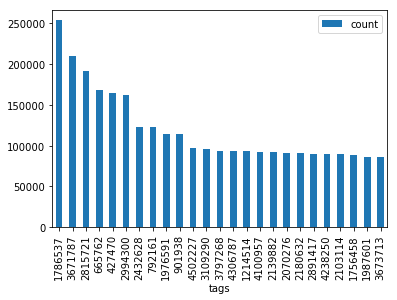

In [10]:
## TAGS

#start timer
t_start = time.time()

cnt=collections.Counter()
for l in itemData['tags']:
    cnt.update(l)
    
bag_tags=set(cnt.keys())
print "There are",len(bag_tags),"different tags keywords"

#end timer
t_end=time.time()

t=pd.DataFrame(cnt.most_common(25),columns=['tags','count']).set_index(['tags'])
t.plot(kind='bar')
t.head()

Total of 10188 common keywords btw Job Roles and Title from a total of 13817 different keywords


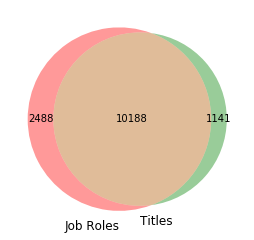

In [11]:
## Now looks for intersections
n_jobroles=len(bag_jobroles)
n_titles=len(bag_title)
n_tags=len(bag_tags)
n_jobroles_titles=len(bag_jobroles.intersection(bag_title))
n_jobroles_tags=len(bag_jobroles.intersection(bag_tags))
n_titles_tags=len(bag_tags.intersection(bag_title))
n_just_jobroles=len((bag_jobroles.difference(bag_title)).difference(bag_tags))
n_just_titles=len((bag_title.difference(bag_jobroles)).difference(bag_tags))
n_just_tags=len((bag_tags.difference(bag_title)).difference(bag_jobroles))
n_just_jobroles_titles=len((bag_jobroles.intersection(bag_title)).difference(bag_tags))
n_just_titles_tags=len((bag_title.intersection(bag_tags)).difference(bag_jobroles))
n_just_jobroles_tags=len((bag_jobroles.intersection(bag_tags)).difference(bag_title))
n_all=len(bag_jobroles.intersection(bag_title).intersection(bag_tags))

from matplotlib_venn import venn2, venn2_circles
venn2(subsets={'10': n_jobroles-n_jobroles_titles, '01': n_titles-n_jobroles_titles, '11': n_jobroles_titles}, set_labels = ('Job Roles', 'Titles'))
    
print "Total of",len(bag_jobroles.intersection(bag_title)),"common keywords btw Job Roles and Title from a total of",\
      len(bag_jobroles.union(bag_title)),"different keywords"



Total of 9806 common keywords btw Job Roles and Tags from a total of 99328 different keywords


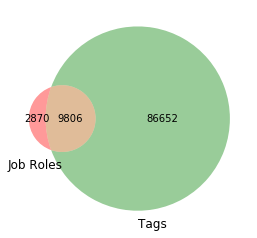

In [12]:
from matplotlib_venn import venn2, venn2_circles
venn2(subsets={'10': n_jobroles-n_jobroles_tags, '01': n_tags-n_jobroles_tags, '11': n_jobroles_tags}, set_labels = ('Job Roles', 'Tags'))
    
print "Total of",len(bag_jobroles.intersection(bag_tags)),"common keywords btw Job Roles and Tags from a total of",\
      len(bag_jobroles.union(bag_tags)),"different keywords"

Total of 9388 common keywords btw Tags and Title from a total of 98399 different keywords


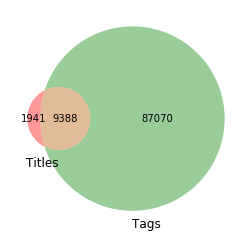

In [13]:
from matplotlib_venn import venn2
venn2(subsets={'10': n_titles-n_titles_tags, '01': n_tags-n_titles_tags, '11': n_titles_tags}, set_labels = ('Titles', 'Tags'))
    
print "Total of",len(bag_tags.intersection(bag_title)),"common keywords btw Tags and Title from a total of",\
      len(bag_tags.union(bag_title)),"different keywords"

<matplotlib_venn._common.VennDiagram instance at 0x000000008DA2B5C8>

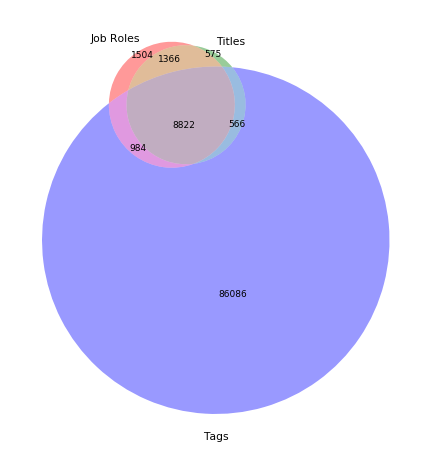

In [15]:
from matplotlib_venn import venn3
plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 9})
venn3(subsets={'100':n_just_jobroles,'010':n_just_titles,'001':n_just_tags,'110':n_just_jobroles_titles,'111':n_all,\
               '011':n_just_titles_tags,'101':n_just_jobroles_tags},set_labels=('Job Roles','Titles','Tags'))


## Study how related are keyword coincidence (btw jobrols and titles/tags) in positive interactions


In [4]:
interactionsData.groupby(['interaction_type']).size()

interaction_type
1    6867579
2     281672
3     117843
4     906836
5     100971
dtype: int64

#### Create a positive interactions dataframe

In [39]:
positiveInt=interactionsData[(interactionsData['interaction_type']==1) | (interactionsData['interaction_type']==2) |\
                             (interactionsData['interaction_type']==3) | (interactionsData['interaction_type']==5)]
positiveInt=positiveInt[['user_id','item_id','interaction_type']]
print positiveInt.shape
#Join with all users
positiveInt=positiveInt.set_index('user_id').join(userData.set_index('id')['jobroles'])
positiveInt=positiveInt.reset_index()
positiveInt=positiveInt.set_index('item_id').join(itemData.set_index('id')[['title','tags']])
positiveInt=positiveInt.reset_index()
positiveInt.columns=['item_id','user_id','interaction_type','jobroles','title','tags']
print positiveInt.shape
positiveInt.head()

(7368065, 3)
(7368065, 6)


,item_id,user_id,interaction_type,jobroles,title,tags
0,5,1142552,1,"[1467657, 1987601, 1208382]","[3859656, 978712, 753522, 3003185, 3027529, 14...","[1412475, 520883, 2120727, 2180632, 792161, 19..."
1,13,54187,1,"[1575670, 2139882, 3113130, 198208, 3853510, 7...",[819772],"[595799, 270830, 3014020, 3105078, 1500199, 37..."
2,13,304213,1,"[3038339, 819772, 3893763]",[819772],"[595799, 270830, 3014020, 3105078, 1500199, 37..."
3,13,304213,1,"[3038339, 819772, 3893763]",[819772],"[595799, 270830, 3014020, 3105078, 1500199, 37..."
4,13,328392,1,[478421],[819772],"[595799, 270830, 3014020, 3105078, 1500199, 37..."


#### Interactions 1 (clicks)

In [19]:
total=len(positiveInt[positiveInt['interaction_type']==1])
total_jobroles_title=sum([(1 if (i==1 and len(set(j).intersection(set(k)))>0) else 0) for i,j,k in zip(positiveInt['interaction_type'],positiveInt['jobroles'],positiveInt['title'])])
total_jobroles_tags=sum([(1 if (i==1 and len(set(j).intersection(set(k)))>0) else 0) for i,j,k in zip(positiveInt['interaction_type'],positiveInt['jobroles'],positiveInt['tags'])])

print "For interactions type 1:"
print total,total_jobroles_title,total_jobroles_tags
print "Jobroles-Title coincidence in positive interactions:",(np.float32(total_jobroles_title)/np.float32(total))*100.0,"%" 
print "Jobroles-Tags coincidence in positive interactions:",(np.float32(total_jobroles_tags)/np.float32(total)) *100.0,"%"

For interactions type 1:
6867579 1059553 1420891
Jobroles-Title coincidence in positive interactions: 15.4283329844 %
Jobroles-Tags coincidence in positive interactions: 20.6898391247 %


#### Regarding interactions type 2 & 3

In [20]:
total=len(positiveInt[positiveInt['interaction_type']==2])
total_jobroles_title=sum([(1 if (i==2 and len(set(j).intersection(set(k)))>0) else 0) for i,j,k in zip(positiveInt['interaction_type'],positiveInt['jobroles'],positiveInt['title'])])
total_jobroles_tags=sum([(1 if (i==2 and len(set(j).intersection(set(k)))>0) else 0) for i,j,k in zip(positiveInt['interaction_type'],positiveInt['jobroles'],positiveInt['tags'])])

print "For interactions type 2:"
print total,total_jobroles_title,total_jobroles_tags
print "Jobroles-Title coincidence in positive interactions:",(np.float32(total_jobroles_title)/np.float32(total))*100.0,"%" 
print "Jobroles-Tags coincidence in positive interactions:",(np.float32(total_jobroles_tags)/np.float32(total)) *100.0,"%"

For interactions type 2:
281672 40952 57091
Jobroles-Title coincidence in positive interactions: 14.5388960838 %
Jobroles-Tags coincidence in positive interactions: 20.2686101198 %


In [21]:
total=len(positiveInt[positiveInt['interaction_type']==3])
total_jobroles_title=sum([(1 if (i==3 and len(set(j).intersection(set(k)))>0) else 0) for i,j,k in zip(positiveInt['interaction_type'],positiveInt['jobroles'],positiveInt['title'])])
total_jobroles_tags=sum([(1 if (i==3 and len(set(j).intersection(set(k)))>0) else 0) for i,j,k in zip(positiveInt['interaction_type'],positiveInt['jobroles'],positiveInt['tags'])])

print "For interactions type 3:"
print total,total_jobroles_title,total_jobroles_tags
print "Jobroles-Title coincidence in positive interactions:",(np.float32(total_jobroles_title)/np.float32(total))*100.0,"%" 
print "Jobroles-Tags coincidence in positive interactions:",(np.float32(total_jobroles_tags)/np.float32(total)) *100.0,"%"

For interactions type 3:
117843 24716 32110
Jobroles-Title coincidence in positive interactions: 20.9736689925 %
Jobroles-Tags coincidence in positive interactions: 27.2481173277 %


#### Regardng interactions type 5

In [22]:
total=len(positiveInt[positiveInt['interaction_type']==5])
total_jobroles_title=sum([(1 if (i==5 and len(set(j).intersection(set(k)))>0) else 0) for i,j,k in zip(positiveInt['interaction_type'],positiveInt['jobroles'],positiveInt['title'])])
total_jobroles_tags=sum([(1 if (i==5 and len(set(j).intersection(set(k)))>0) else 0) for i,j,k in zip(positiveInt['interaction_type'],positiveInt['jobroles'],positiveInt['tags'])])

print "For interactions type 5:"
print total,total_jobroles_title,total_jobroles_tags
print "Jobroles-Title coincidence in positive interactions:",(np.float32(total_jobroles_title)/np.float32(total))*100.0,"%" 
print "Jobroles-Tags coincidence in positive interactions:",(np.float32(total_jobroles_tags)/np.float32(total)) *100.0,"%"

For interactions type 5:
100971 44042 54064
Jobroles-Title coincidence in positive interactions: 43.6184644699 %
Jobroles-Tags coincidence in positive interactions: 53.5440862179 %


#### Regarding interactions 4 (for only-deleted)

In [25]:
userItemInt=interactionsData.groupby(['user_id','item_id','interaction_type']).size().unstack(fill_value=0.0)
userItemInt.columns=(['1','2','3','4','5'])
userItemInt['1']=userItemInt['1'].astype(np.int16)
userItemInt['2']=userItemInt['2'].astype(np.int16)
userItemInt['3']=userItemInt['3'].astype(np.int16)
userItemInt['4']=userItemInt['4'].astype(np.int16)
userItemInt['5']=userItemInt['5'].astype(np.int16)
userItemInt=userItemInt.reset_index()

#Join with all users
userItemInt=userItemInt.set_index('user_id').join(userData.set_index('id')['jobroles'])
userItemInt=userItemInt.set_index('item_id').join(itemData.set_index('id')[['title','tags']])

delOnlyInt=userItemInt[(userItemInt['4']>0) & (userItemInt['1']==0) & (userItemInt['2']==0) & \
                       (userItemInt['3']==0) & (userItemInt['5']==0)]
total=len(delOnlyInt)
total_jobroles_title=sum([(1 if len(set(i).intersection(set(j)))>0 else 0) for i,j in zip(delOnlyInt['jobroles'],delOnlyInt['title'])])
total_jobroles_tags=sum([(1 if len(set(i).intersection(set(j)))>0 else 0) for i,j in zip(delOnlyInt['jobroles'],delOnlyInt['tags'])])

print "For interactions type 4:"
print total,total_jobroles_title,total_jobroles_tags
print "Jobroles-Title coincidence in delete only interactions:",(np.float32(total_jobroles_title)/np.float32(total))*100.0,"%" 
print "Jobroles-Tags coincidence in delete only interactions:",(np.float32(total_jobroles_tags)/np.float32(total)) *100.0,"%"

For interactions type 4:
856849 209950 267730
Jobroles-Title coincidence in delete only interactions: 24.5025664568 %
Jobroles-Tags coincidence in delete only interactions: 31.2458783388 %


## We can observe as insights:

 - Not so big matching btw jobreles/title/tags keywords for positive interactions (the commited the type of interactions the bigger)

For types 1 & 2:
    
 - Only 14/15% interactions positive are based on some macthing btw jobrols/title keywords
 - Only 20% interactions positive are based on some macthing btw jobrols/tags keywords   
    
For types 3 (that requires more commitment to the job):
    
 - Only 21% interactions positive are based on some macthing btw jobrols/title keywords
 - Only 27% interactions positive are based on some macthing btw jobrols/tags keywords   
   
For types 5 (recruiters should risk less):
    
 - Only 43,5% interactions positive are based on some macthing btw jobrols/title keywords
 - Only 53,5% interactions positive are based on some macthing btw jobrols/tags keywords   
    
For delete only interactions not big differences (confirms symetrical relation jobroles/titles/tags in pos/neg. interactions)

Conclusions:
    
 - We cannot based recommendation on jobroles/titles/tags, we need alternatives
 - For interactions type 5 we can rely more in jobroles/titles/tags
 - We dont know if this low relationship is only aspirational or jobroles/titles/tags is no enough to express richness
    
    

# Build a LDA model based for items

<a name="topics"></a>

We will create a LDA model using items as docs, the keywords (titles, tags) as the words.
We will add some other features as "tags" (keywords)

Objective is threefold:
 - Have a extended representation of item as title/tags are not easily used and not option to expanad to 100000 column features vector
 - Use the LDA model to represent similarity btw items
 - Use users interactions (to derive used keywords) or just titles and other-used-as-keyword-features (cold users) to do similarity searches
        

In [21]:
# http://miningthedetails.com/blog/python/lda/GensimLDA/

In [26]:
def apyRecsysItemToBow(item):
    extra=[]
    if (item.discipline_id>0):
        extra=extra+["disc"+str(item.discipline_id)]
    if (item.industry_id>0):
        extra=extra+["indus"+str(item.industry_id)]
    if (item.career_level>0):
        extra=extra+["career"+str(item.career_level)]
    extra=extra+[item.country]
    if (item.region>0):
        extra=extra+["reg"+str(item.region)]
    bow=",".join(map(str,extra+item['title']+item['tags']))
    return bow

#start timer
t_start = time.time()                               

#corpus=itemData[['title','tags']].apply(lambda row: [str(x) for x in row['title']]+[str(y) for y in row['tags']],axis=1) 
docs=itemData.apply(lambda row: apyRecsysItemToBow(row),axis=1).apply(lambda row: row.split(","))
#corpus=[map(str,x+y) for (x,y) in zip(itemData['title'],itemData['tags'])]
#corpus=[map(str,x) for x in corpus]

#end timer
t_end=time.time()
print "Time invested (create docs corpus) "+str((t_end-t_start))+" s"

print docs.shape
docs.head(10)

Time invested (create dictionary)203.781000137 s
(1306054L,)


0    [disc15, indus9, career3, de, reg7, 3323880, 4...
1    [disc5, indus18, career3, de, reg1, 2994300, 6...
2    [disc10, indus1, career1, de, reg1, 3275701, 1...
3    [disc8, indus9, career3, de, reg3, 2343474, 24...
4    [disc8, indus3, career4, at, 2003688, 2233488,...
5    [disc5, indus16, career3, de, reg1, 2139882, 3...
6    [disc18, indus2, career3, de, 1385885, 1196844...
7    [disc22, indus17, career3, ch, 3739444, 294560...
8    [disc15, indus9, career3, de, 732567, 2853244,...
9    [disc15, indus1, career3, de, reg2, 37028, 492...
dtype: object

### Build a LDA model of N topics (empirical choice within our computation limits)

We observe improvement in higher number of topics (50, 100, 150, ...), but not time/resources to find best number of topics or to try much higher number of topics.

For the number of passes we just tried as much as we can assuming our computation resources.

 - Incremental building and multicore
 - 10/20/30 passes to minimize randomness (limits on computation) --> Depen on numebr of topics


In [101]:
import gensim
from gensim import corpora

#start timer
t_start = time.time()                               

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary=corpora.Dictionary(docs)
print(dictionary)
dictionary.save("lda/recsys_dict_300topic.pkl")

#end timer
t_end=time.time()
print "Time invested (create dictionary)"+str((t_end-t_start))+" s"

# Creating the object for LDA model using gensim library
LdaMulticore = gensim.models.ldamulticore.LdaMulticore

#start timer
t_start = time.time()   

# Do a loop for batch incremental size
batch_size=50000
i=0
while i<len(docs):
    j=i+batch_size
    print "generating from "+str(i)+" to "+str(j-1)
    #start timer
    t_start_inner = time.time() 
    doc_term_matrix=[dictionary.doc2bow(doc) for doc in docs[i:j]]
    if i==0:
        lda_model=LdaMulticore(doc_term_matrix,num_topics=300,id2word=dictionary,workers=4,passes=8)
    else:
        lda_model.update(doc_term_matrix)
    lda_model.save('lda/ldamodel_300topic.pkl')
    i=j
    #end timer
    t_end=time.time()
    print "Time invested (this step)"+str((t_end-t_start_inner))+" s"
    
#end timer
t_end=time.time()
print "Time invested (whole lda training)"+str((t_end-t_start))+" s"


Dictionary(98470 unique tokens: [u'1055485', u'2668995', u'2553225', u'2983263', u'839790']...)
Time invested (create dictionary)74.1819999218 s
generating from 0 to 49999
Time invested (this step)1534.77999997 s
generating from 50000 to 99999
Time invested (this step)1122.99499989 s
generating from 100000 to 149999
Time invested (this step)1120.36600018 s
generating from 150000 to 199999
Time invested (this step)1166.71299982 s
generating from 200000 to 249999
Time invested (this step)1127.23900008 s
generating from 250000 to 299999
Time invested (this step)1122.31999993 s
generating from 300000 to 349999
Time invested (this step)1137.67799997 s
generating from 350000 to 399999
Time invested (this step)1312.26400018 s
generating from 400000 to 449999
Time invested (this step)1130.0769999 s
generating from 450000 to 499999
Time invested (this step)1129.60299993 s
generating from 500000 to 549999
Time invested (this step)1120.352 s
generating from 550000 to 599999
Time invested (this st

### CONCLUSION

 - We have analyzed terms-based fields and interactions
 - We have build a LDA model on items 
 - Go to "Recys-Snippet-Helper-Target-Non-Cold-User-V3" notebook to use this model for CB recommendation
    
 - Next sections are experiments on jobroles/title/tags correlations 

### Let's re-analize jobroles/title/tags relatioship in terms of the LDA 

Note that it's true that now it's affected by introducing industry/disciplined/country/... keywords in te LDA but anyway it will test it.

Let's measure for every pair of [item,user] interaction the % of relation ship based on: cosine distance (using gensim similarity matrix) btw the user as a "doc" and the item as a "doc".


In [28]:
print interactionsData.shape
print itemData.shape
itemDataWithIntListIDs=pd.DataFrame(sorted(interactionsData['item_id'].unique()),columns=['item_id']).set_index('item_id')

(8274901, 5)
(1306054, 13)


#### let's work on items with interactions

In [29]:
itemDataWithInt=itemData.join(itemDataWithIntListIDs,on='id',how='inner')
print itemDataWithInt.shape
itemDataWithInt.head()

(538683, 13)


,id,title,career_level,discipline_id,industry_id,country,is_payed,region,latitude,longitude,employment,tags,created_at
2,80,"[3275701, 157228, 4179835]",1,10,1,de,0,1,48.8,8.1,1,"[3275701, 4179835, 910844, 4050466, 258464, 13...",1483570800
7,140,"[3739444, 2945601, 3246051, 48128, 4098162, 38...",3,22,17,ch,0,0,46.9,7.4,1,"[3418248, 540282, 1627300]",1479942000
14,240,"[4313058, 864194, 3999650, 4368523, 3606563]",3,16,3,de,0,2,47.9,12.2,1,"[3323880, 816249, 2512002, 903605, 2436509, 12...",1473372000
20,310,"[3842576, 310589, 4099592, 2629116]",3,13,9,at,0,0,47.1,15.5,1,"[3351095, 2845746, 3671787, 2379175, 3989138, ...",1483138800
23,340,"[287796, 2280545]",3,13,23,at,0,0,48.0,13.1,1,"[2139882, 3989138, 427470, 4496721, 2994300, 1...",1484607600


#### We can now create the similarity matrix

For this matrix we use the reduced corpus of items with interactions

In [30]:
def apyRecsysItemToBow(item):
    extra=[]
    if (item.discipline_id>0):
        extra=extra+["disc"+str(item.discipline_id)]
    if (item.industry_id>0):
        extra=extra+["indus"+str(item.industry_id)]
    if (item.career_level>0):
        extra=extra+["career"+str(item.career_level)]
    extra=extra+[item.country]
    if (item.region>0):
        extra=extra+["reg"+str(item.region)]
    bow=",".join(map(str,extra+item['title']+item['tags']))
    return bow

#start timer
t_start = time.time()                               

targetDocsItemWithInt=itemDataWithInt.apply(lambda row: apyRecsysItemToBow(row),axis=1).apply(lambda row: row.split(","))

#end timer
t_end=time.time()
print "Time invested (create dictionary)"+str((t_end-t_start))+" s"

print targetDocsItemWithInt.shape
targetDocsItemWithInt.head(10)

Time invested (create dictionary)89.986000061 s
(538683L,)


2     [disc10, indus1, career1, de, reg1, 3275701, 1...
7     [disc22, indus17, career3, ch, 3739444, 294560...
14    [disc16, indus3, career3, de, reg2, 4313058, 8...
20    [disc13, indus9, career3, at, 3842576, 310589,...
23    [disc13, indus23, career3, at, 287796, 2280545...
24    [disc4, indus16, career3, de, reg7, 2803519, 4...
26    [disc15, indus7, career3, de, reg1, 1168089, 3...
27    [disc11, indus18, career3, de, reg9, 2436485, ...
29    [disc13, indus16, career3, de, reg1, 2343474, ...
30    [disc8, indus16, career3, de, reg6, 2942918, 3...
dtype: object

#### Let's create a similarity matrix for items with interactions

In [100]:
import gensim
from gensim import corpora, models, similarities

# Reload dictionary associate to our LDA -- Optional, just if we don't start from beginning
dictionary = corpora.Dictionary.load('lda/recsys_dict_300topic.pkl')
print dictionary

#corpus here is ours "docs" list 
#lda_model is our latent space model
# we can reload from disk if need be
lda_model=gensim.models.ldamulticore.LdaMulticore.load("lda/ldamodel_300topic.pkl")

#start timer
t_start=time.time()   

# We need to rebuild doc_term_matrix == "corpus" --> for the documents we want to build the matrix
doc_term_matrix=[dictionary.doc2bow(doc) for doc in targetDocsItemWithInt] 

# end timer
t_end=time.time()
print "Time invested (term matrix) "+str((t_end-t_start))+" s"

# we can create a similarity matrix --> we can use our latent space directly or use it on other corpus
##index=similarities.MatrixSimilarity(lsi[corpus]) # transform corpus to LSI space and index it

# First we need to transform our "corpus" to our LDA space model
#start timer
t_start=time.time()                          

lda_corpus=lda_model[doc_term_matrix]

# end timer
t_end=time.time()
print "Time invested (lda_corpus) "+str((t_end-t_start))+" s"

# check topics a N features
n_features=len(lda_model.show_topics(-1))
print n_features

#start timer
t_start=time.time()

## If very big corpus let's go for disk matrix --> This is the case, memory LDA are for 1Gb meory or so
index_disk=similarities.Similarity(output_prefix='lda/index/lda300index_itemWithInt',num_features=250,corpus=lda_corpus,num_best=None,chunksize=256,shardsize=32768)
index_disk.save("lda/index/lda300index_itemWithInt.pkl")

# In memory (may not resist big numbers) --> We used in this case the disk option
#index_mem=similarities.MatrixSimilarity(lda_corpus) # transform corpus to LDA space and index it

#end timer
t_end=time.time()
print "Time invested (index_disk)"+str((t_end-t_start))+" s"

IOError: [Errno 2] No such file or directory: 'lda/recsys_dict_300topic.pkl'

#### Let's test and reload the similarity matrix

In [33]:
import gensim
from gensim import corpora, models, similarities

#start timer
t_start=time.time()

index_disk=similarities.Similarity.load("lda/index/lda250index_itemWithInt.pkl")

#end timer
t_end=time.time()
print "Time invested (reload index)"+str((t_end-t_start))+" s"

Time invested (reload index)0.0160000324249 s


#### Let's do a test query to validate the similarity matrix (use the first item)

In [34]:
targetDocsItemWithInt[0:1].tolist()

[['disc10',
  'indus1',
  'career1',
  'de',
  'reg1',
  '3275701',
  '157228',
  '4179835',
  '3275701',
  '4179835',
  '910844',
  '4050466',
  '258464',
  '1339355']]

In [35]:
query="disc10 indus1 career1 de reg1 3275701 157228 4179835 3275701 4179835"
vec_bow=dictionary.doc2bow(query.split())
vec_lda=lda_model[vec_bow] # convert the query to LDA space

index_disk.num_best = 10
## Get top 10 similar "docs" (items)
sims=index_disk[vec_lda] # perform a similarity query against the corpus
print sims

#index_disk.num_best = None
## Get top 10 similar "docs" (items)
#sims=index_disk[vec_lda] # perform a similarity query against the corpus
#sims=sorted(enumerate(sims),key=lambda item:-item[1])[0:10]
#print(sims) # print sorted (document number, similarity score) 2-tuples

[(0, 0.92250329256057739), (526288, 0.8202131986618042), (97640, 0.81684195995330811), (211151, 0.81603223085403442), (500043, 0.80338573455810547), (233336, 0.79697012901306152), (313698, 0.78459846973419189), (7919, 0.78269529342651367), (425815, 0.77918243408203125), (125317, 0.7765573263168335)]


#### Know we can measure again correlation btw interaction and "intersection" of jobroles/title/tags

First we prepare the positive iterections dataframe with the corpus-index of values

In [40]:
print positiveInt.shape
positiveIntMore=positiveInt.join(itemDataWithInt.reset_index(drop=True).reset_index().set_index('id')['index'],on='item_id')
positiveIntMore.columns=['item_id','user_id','interaction_type','jobroles','title','tags','index_corpus']
print positiveIntMore.shape
positiveIntMore.head()

(7368065, 6)
(7368065, 7)


,item_id,user_id,interaction_type,jobroles,title,tags,index_corpus
0,5,1142552,1,"[1467657, 1987601, 1208382]","[3859656, 978712, 753522, 3003185, 3027529, 14...","[1412475, 520883, 2120727, 2180632, 792161, 19...",214839
1,13,54187,1,"[1575670, 2139882, 3113130, 198208, 3853510, 7...",[819772],"[595799, 270830, 3014020, 3105078, 1500199, 37...",160607
2,13,304213,1,"[3038339, 819772, 3893763]",[819772],"[595799, 270830, 3014020, 3105078, 1500199, 37...",160607
3,13,304213,1,"[3038339, 819772, 3893763]",[819772],"[595799, 270830, 3014020, 3105078, 1500199, 37...",160607
4,13,328392,1,[478421],[819772],"[595799, 270830, 3014020, 3105078, 1500199, 37...",160607


#### Now, we need to add the original users info for featured-based-terms: discipline, industry, ....

In [41]:
positiveIntMore=positiveIntMore.join(userData.set_index('id')[['discipline_id','industry_id','career_level','country','region']],on='user_id')
print positiveIntMore.shape
positiveIntMore.head()

(7368065, 12)


,item_id,user_id,interaction_type,jobroles,title,tags,index_corpus,discipline_id,industry_id,career_level,country,region
0,5,1142552,1,"[1467657, 1987601, 1208382]","[3859656, 978712, 753522, 3003185, 3027529, 14...","[1412475, 520883, 2120727, 2180632, 792161, 19...",214839,0,0,3,de,0
1,13,54187,1,"[1575670, 2139882, 3113130, 198208, 3853510, 7...",[819772],"[595799, 270830, 3014020, 3105078, 1500199, 37...",160607,0,17,4,de,2
2,13,304213,1,"[3038339, 819772, 3893763]",[819772],"[595799, 270830, 3014020, 3105078, 1500199, 37...",160607,0,6,3,de,2
3,13,304213,1,"[3038339, 819772, 3893763]",[819772],"[595799, 270830, 3014020, 3105078, 1500199, 37...",160607,0,6,3,de,2
4,13,328392,1,[478421],[819772],"[595799, 270830, 3014020, 3105078, 1500199, 37...",160607,0,0,3,de,0


#### Let's try to measure correlation, let's try a small subset for example on interaction 2

In [86]:
def apyRecsysUserToBow(user):
    extra=[]
    if (user.discipline_id>0):
        extra=extra+["disc"+str(user.discipline_id)]
    if (user.industry_id>0):
        extra=extra+["indus"+str(user.industry_id)]
    if (user.career_level>0):
        extra=extra+["career"+str(user.career_level)]
    extra=extra+[user.country]
    if (user.region>0):
        extra=extra+["reg"+str(user.region)]
    bow=",".join(map(str,extra+user['jobroles']))
    return bow

def calcSimilitude(row,dictionary,lda_model,index):
    bow=apyRecsysUserToBow(row)
    vecBbow=dictionary.doc2bow(bow.split())
    vecLda=lda_model[vec_bow] # convert the query to LDA space  
    index.num_best=None
    sims=index[vecLda]
    return sims[row['index_corpus']]

#start timer
t_start=time.time()

intType2=positiveIntMore[positiveIntMore['interaction_type']==2]

#x=positiveIntMore[0:5000].apply(lambda row: calcSimilitude(row,dictionary,lda_model,index_disk),axis=1)
topic_intersect=[calcSimilitude(row,dictionary,lda_model,index_disk) for ind,row in intType2[0:10000].iterrows()]

#end timer
t_end=time.time()
print "Time invested "+str((t_end-t_start))+" s"

##positiveIntMore[positiveIntMore['interaction_type']==2]

Time invested 1136.49100018 s


topic_intersect=pd.Series(topic_intersect)

#### Let's see improvement in %

In [88]:
print 100.0*len(topic_intersect[topic_intersect>0.0])/(len(topic_intersect)*1.0),"%"

0.16236

#### Do similar test on other interactions (for small subset for the computation cost)

In [89]:
#start timer
t_start=time.time()

intType1=positiveIntMore[positiveIntMore['interaction_type']==1]

topic_intersect=[calcSimilitude(row,dictionary,lda_model,index_disk) for ind,row in intType1[0:10000].iterrows()]

#end timer
t_end=time.time()
print "Time invested "+str((t_end-t_start))+" s"

topic_intersect=pd.Series(topic_intersect)
print "Test % of some interactions 1 with some LDA similarity:" 
print 100.0*len(topic_intersect[topic_intersect>0.0])/(len(topic_intersect)*1.0),"%"

Time invested 45.2170000076 s


0.159

In [99]:
#start timer
t_start=time.time()

intType5=positiveIntMore[positiveIntMore['interaction_type']==5]

topic_intersect=[calcSimilitude(row,dictionary,lda_model,index_disk) for ind,row in intType5[0:10000].iterrows()]

#end timer
t_end=time.time()
print "Time invested "+str((t_end-t_start))+" s"

topic_intersect=pd.Series(topic_intersect)
print "Test % of some interactions 5 with some LDA similarity:" 
print 100.0*len(topic_intersect[topic_intersect>0.0])/(len(topic_intersect)*1.0),"%"

Time invested 452.096999884 s
Test % of some interactions 5 with some LDA similarity:
12.0 %


### Insight: No clear increased correlation, but let's try to repeat using user info with non-NAs

In [98]:
#start timer
t_start=time.time()

intType2nonNAs=positiveIntMore[(positiveIntMore['interaction_type']==2) & (positiveIntMore['discipline_id']>0) &\
                               (positiveIntMore['industry_id']>0) & (positiveIntMore['career_level']>0) &\
                               (positiveIntMore['region']>0)\
                              ]

topic_intersect=[calcSimilitude(row,dictionary,lda_model,index_disk) for ind,row in intType2nonNAs[0:10000].iterrows()]

#end timer
t_end=time.time()
print "Time invested "+str((t_end-t_start))+" s"

topic_intersect=pd.Series(topic_intersect)
print "Test % of some interactions 2 (non NAs) with some LDA similarity:" 
print 100.0*len(topic_intersect[topic_intersect>0.0])/(len(topic_intersect)*1.0),"%"

Time invested 477.901000023 s
Test % of some interactions 2 (non NAs) with some LDA similarity:
16.06 %


In [97]:
#start timer
t_start=time.time()

intType1nonNAs=positiveIntMore[(positiveIntMore['interaction_type']==1) & (positiveIntMore['discipline_id']>0) &\
                               (positiveIntMore['industry_id']>0) & (positiveIntMore['career_level']>0) &\
                               (positiveIntMore['region']>0)\
                              ]

topic_intersect=[calcSimilitude(row,dictionary,lda_model,index_disk) for ind,row in intType1nonNAs[0:10000].iterrows()]

#end timer
t_end=time.time()
print "Time invested "+str((t_end-t_start))+" s"

topic_intersect=pd.Series(topic_intersect)
print "Test % of some interactions 1 (non NAs) with some LDA similarity:" 
print 100.0*len(topic_intersect[topic_intersect>0.0])/(len(topic_intersect)*1.0),"%"

Time invested 429.377000093 s
Test % of some interactions 1 (non NAs) with some LDA similarity:
13.98 %


### More experiments

#### Build another LDA model for items but only based on title and not including discipline/industry/career

In [6]:
# only title
def apiRecsysItemToBowSimple(item):
    bow=",".join(map(str,item['title']))
    return bow

#start timer
t_start = time.time()                               

docs=itemData.apply(lambda row: apiRecsysItemToBowSimple(row),axis=1).apply(lambda row: row.split(","))

#end timer
t_end=time.time()
print "Time invested (create simple docs corpus) "+str((t_end-t_start))+" s"

print docs.shape
docs.head(10)

Time invested (create simple docs corpus) 43.0089998245 s
(1306054L,)


0                                                   []
1           [2994300, 665762, 901938, 127655, 3680343]
2                           [3275701, 157228, 4179835]
3                                            [2343474]
4                                            [2003688]
5                          [2139882, 3113130, 3055643]
6                                   [1385885, 1196844]
7    [3739444, 2945601, 3246051, 48128, 4098162, 38...
8                   [732567, 2853244, 310589, 2304652]
9                                                   []
dtype: object

In [17]:
docs=docs[[True if (len(i)>0 and i[0]!='') else False for i in docs]]

In [19]:
import gensim
from gensim import corpora

#start timer
t_start = time.time()                               

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary=corpora.Dictionary(docs)
print(dictionary)
dictionary.save("lda/recsys_dict_simple_title_100topic.pkl")

#end timer
t_end=time.time()
print "Time invested (create dictionary)"+str((t_end-t_start))+" s"

# Creating the object for LDA model using gensim library
LdaMulticore = gensim.models.ldamulticore.LdaMulticore

#start timer
t_start = time.time()   

# Do a loop for batch incremental size
batch_size=50000
i=0
while i<len(docs):
    j=i+batch_size
    print "generating from "+str(i)+" to "+str(j-1)
    #start timer
    t_start_inner = time.time() 
    doc_term_matrix=[dictionary.doc2bow(doc) for doc in docs[i:j]]
    if i==0:
        lda_model=LdaMulticore(doc_term_matrix,num_topics=100,id2word=dictionary,workers=3,passes=5)
    else:
        lda_model.update(doc_term_matrix)
    lda_model.save('lda/ldamodel_simple_title_100topic.pkl')
    i=j
    #end timer
    t_end=time.time()
    print "Time invested (this step)"+str((t_end-t_start_inner))+" s"
    
#end timer
t_end=time.time()
print "Time invested (whole lda training)"+str((t_end-t_start))+" s"

Dictionary(11329 unique tokens: [u'2790498', u'4512151', u'2942918', u'3591036', u'2653966']...)
Time invested (create dictionary)29.8150000572 s
generating from 0 to 49999
Time invested (this step)368.28399992 s
generating from 50000 to 99999
Time invested (this step)306.773999929 s
generating from 100000 to 149999
Time invested (this step)309.181999922 s
generating from 150000 to 199999
Time invested (this step)301.976000071 s
generating from 200000 to 249999
Time invested (this step)333.572000027 s
generating from 250000 to 299999
Time invested (this step)374.828000069 s
generating from 300000 to 349999
Time invested (this step)317.749000072 s
generating from 350000 to 399999
Time invested (this step)317.909999847 s
generating from 400000 to 449999
Time invested (this step)311.24000001 s
generating from 450000 to 499999
Time invested (this step)345.973999977 s
generating from 500000 to 549999
Time invested (this step)343.827000141 s
generating from 550000 to 599999
Time invested (th